<a href="https://colab.research.google.com/github/Soarex16/Kaggle-submissions/blob/master/Fashion_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd

import copy

import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt

In [0]:
TRAIN_PATH = '/content/fashion-mnist_train.csv'
TEST_PATH = '/content/fashion-mnist_test.csv'

In [0]:
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

In [0]:
# Prepare train data
x_train = np.array(df_train.iloc[:, 1:]).reshape(-1, 1, 28, 28).astype(float)
y_train = np.array(df_train.iloc[:, 0])

In [0]:
# And test data
x_test = np.array(df_test).reshape(-1, 1, 28, 28).astype(float)
y_test = np.array(df_test.iloc[:, 0])

In [0]:
class FashionMNISTDataset(Dataset):
    '''Fashion MNIST Dataset'''
    def __init__(self, csv_file, train=True, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file
            transform (callable): Optional transform to apply to sample
        """
        
        data = pd.read_csv(csv_file)
        
        self.X = np.array(data.iloc[:, 1:] if train else data).reshape(-1, 1, 28, 28).astype(float)
        self.Y = np.array(data.iloc[:, 0])
        
        del data;
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        item = self.X[idx]
        label = self.Y[idx]
        
        if self.transform:
            item = self.transform(item)
        
        return (item, label)

In [0]:
train_dataset = FashionMNISTDataset(csv_file=TRAIN_PATH)
test_dataset = FashionMNISTDataset(csv_file=TEST_PATH, train=False)

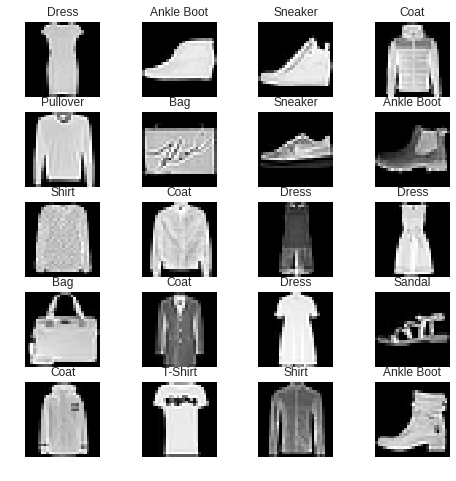

In [51]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 
              3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

fig = plt.figure(figsize=(8,8))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    
    fig.add_subplot(rows, columns, i)
    
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [0]:
# Simple CNN network

class ConvNet(torch.nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        
        # First convolution
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        
        # Second convolution
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        
        # Dropout, fc and other classification
        self.linear = torch.nn.Sequential(
            torch.nn.Dropout(p = 0.5),
            torch.nn.Linear(32 * 7 * 7, num_classes)
            # torch.nn.Softmax()
        )
        
        
    def forward(self, x):
        y_pred = self.conv1(x)
        y_pred = self.conv2(y_pred)
        
        y_pred = y_pred.reshape(y_pred.size(0), -1)
        y_pred = self.linear(y_pred)
        
        return y_pred



In [113]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [0]:
# Hyperparams
learning_rate = 0.001
num_epochs = 100
batch_size = 300

num_classes = 10

In [115]:
# Our model
model = ConvNet(num_classes).to(device)
model

ConvNet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=1568, out_features=10, bias=True)
  )
)

In [0]:
# Make DataLoaders from Dataset
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [117]:
# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

losses = []

best_model_wts = copy.deepcopy(model.state_dict()) 
best_loss = np.inf

total_step = len(train_loader)
for epoch in range(num_epochs):
    ep_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.float().to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i + 1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            ep_loss = loss.item()
    
    if ep_loss < best_loss:
        best_loss = ep_loss
        best_model_wts = copy.deepcopy(model.state_dict()) 
        
    losses.append(ep_loss)

Epoch [1/100], Step [100/200], Loss: 0.4917
Epoch [1/100], Step [200/200], Loss: 0.3990
Epoch [2/100], Step [100/200], Loss: 0.3828
Epoch [2/100], Step [200/200], Loss: 0.4071
Epoch [3/100], Step [100/200], Loss: 0.3608
Epoch [3/100], Step [200/200], Loss: 0.4141
Epoch [4/100], Step [100/200], Loss: 0.3066
Epoch [4/100], Step [200/200], Loss: 0.3306
Epoch [5/100], Step [100/200], Loss: 0.3130
Epoch [5/100], Step [200/200], Loss: 0.3024
Epoch [6/100], Step [100/200], Loss: 0.2574
Epoch [6/100], Step [200/200], Loss: 0.3223
Epoch [7/100], Step [100/200], Loss: 0.2305
Epoch [7/100], Step [200/200], Loss: 0.2706
Epoch [8/100], Step [100/200], Loss: 0.2733
Epoch [8/100], Step [200/200], Loss: 0.3260
Epoch [9/100], Step [100/200], Loss: 0.2856
Epoch [9/100], Step [200/200], Loss: 0.2596
Epoch [10/100], Step [100/200], Loss: 0.2545
Epoch [10/100], Step [200/200], Loss: 0.2448
Epoch [11/100], Step [100/200], Loss: 0.3665
Epoch [11/100], Step [200/200], Loss: 0.2538
Epoch [12/100], Step [100/20

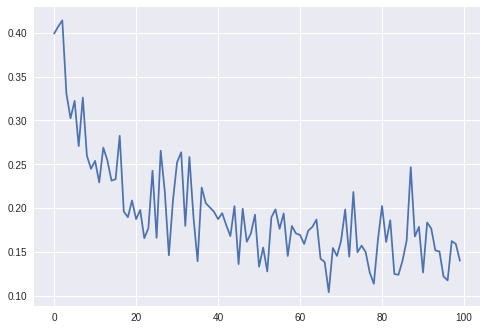

In [118]:
plt.plot(losses)

# **Если честно, то я понятия не имею, почему accuracy такие странные**

In [119]:
# Test the model
model.load_state_dict(best_model_wts)
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.float().to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model on the 10000 test images: 10.14 %


In [120]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker','Bag', 'Ankle boot']

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.float().to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        c = (predicted == labels).squeeze()
        for i in range(len(outputs)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    if class_total[i] == 0:
        class_total[i] = 1
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of T-shirt/top : 10 %
Accuracy of Trouser :  0 %
Accuracy of Pullover :  0 %
Accuracy of Dress :  0 %
Accuracy of  Coat :  0 %
Accuracy of Sandal :  0 %
Accuracy of Shirt :  0 %
Accuracy of Sneaker :  0 %
Accuracy of   Bag :  0 %
Accuracy of Ankle boot :  0 %


In [0]:
inputs = torch.FloatTensor(test_dataset.X)
outputs = model(inputs.to(device))
# pred = model(torch.FloatTensor(test_loader.dataset.X[0]).to(device)).to('cpu')

In [0]:
_, predicted = torch.max(outputs, 1)

In [123]:
# Write answers
answer_df = pd.DataFrame(data=predicted.cpu().numpy(), columns=['Category'])
answer_df.head()

,Category
0,0
1,1
2,2
3,2
4,3


In [0]:
answer_df['Id'] = answer_df.index

In [0]:
answer_df.to_csv('./fashion_mnist_result.csv', index=False)